In [1]:
from mne.decoding import Vectorizer
import os
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import numpy as np
from sklearn import metrics
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import pandas as pd
from scipy import stats as stats
from scipy.stats import randint as sp_randint
%matplotlib inline

Using TensorFlow backend.


In [2]:
os.chdir('D:\\NING - spindle\\Spindle_by_Graphical_Features')

In [3]:
X_validation,y_validation = pickle.load(open('data/validation/validation.p','rb'))
#X_test,y_test = pickle.load(open('data/test//test.p','rb'))

X_train,y_train = [],[]
for ii in range(10):
    X_train_,y_train_ = pickle.load(open('data/train/train%d.p'%(ii),'rb'))
    X_train.append(X_train_)
    y_train.append(y_train_)
    del X_train_,y_train_
X_train = np.concatenate(X_train,axis=0)
y_train = np.concatenate(y_train,axis=0)

In [4]:
def make_clf():
    clf = []
    clf.append(('vectorizer',Vectorizer()))
    clf.append(('estimator',RandomForestClassifier(n_estimators=100,
                                                   max_depth=50,
                                                   random_state=12345,
                                                  class_weight='balanced')))
    clf = Pipeline(clf)
    return clf

In [5]:
X_train_,y_train_ = pickle.load(open('data/train/train%d.p'%(5),'rb'))

X_train_ = np.concatenate([X_train_,X_validation],axis=0)
y_train_ = np.concatenate([y_train_,y_validation],axis=0)
X_train_,y_train_ = shuffle(X_train_,y_train_)
vectorizer = Vectorizer()
X_train_ = vectorizer.fit_transform(X_train_)
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=4,random_state=12345)

In [11]:
param_dist = {"n_estimators":sp_randint(50,200),
              "class_weight":['balanced'],
                "max_depth": [3, None],
                "max_features": sp_randint(1, 11),
                "min_samples_split": sp_randint(2, 11),
                "min_samples_leaf": sp_randint(1, 11),}
rgrid = RandomizedSearchCV(clf,param_distributions=param_dist,
                          n_iter=20,cv=cv,scoring='roc_auc',)
rgrid.fit(X_train_,y_train_[:,-1])

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=12345, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001734FEB8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000017486A20>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001734F630>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object

In [54]:
def get_best_(ii,random_=True,grid_=True,rgrid_=False):
    X_train_,y_train_ = pickle.load(open('data/train/train%d.p'%(ii),'rb'))
    if random_:
        random_inputs = np.random.rand(X_train_.shape[0],32,16,192)
        random_labels = [0]*X_train_.shape[0]
        random_labels = np_utils.to_categorical(random_labels,2)
        X_train_ = np.concatenate([X_train_,random_inputs],axis=0)
        y_train_ = np.concatenate([y_train_,random_labels],axis=0)
    X_train_ = np.concatenate([X_train_,X_validation],axis=0)
    y_train_ = np.concatenate([y_train_,y_validation],axis=0)
    X_train_,y_train_ = shuffle(X_train_,y_train_)
    vectorizer = Vectorizer()
    X_train_ = vectorizer.fit_transform(X_train_)
    clf = RandomForestClassifier()
    cv = StratifiedKFold(n_splits=4,random_state=12345)
    if grid_:
        param_grid = {"n_estimators":[152,179,190],
                          "max_depth":[None],
                          "class_weight":['balanced'],
              "max_features": [10],
              "min_samples_split": [4, 10],
              "min_samples_leaf": [4],}

        
        grid = GridSearchCV(clf,param_grid=param_grid,cv=cv,scoring='roc_auc',)
        grid.fit(X_train_,y_train_[:,-1])
        return grid
    if rgrid_:
        param_dist = {"n_estimators":sp_randint(50,200),
                      "class_weight":['balanced'],
            "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),}
        rgrid = RandomizedSearchCV(clf,param_distributions=param_dist,
                                  n_iter=100,cv=cv,scoring='roc_auc',)
        rgrid.fit(X_train_,y_train_[:,-1])
        return rgrid

In [28]:
dfs = {}
for ii in range(5):
    best_params_ = []
    for jj in np.random.choice(range(10),10,replace=False):
        cc = get_best_(jj,grid_=False,rgrid_=True,random_=False)
        cc=pd.Series(cc.best_params_).to_frame().T
        best_params_.append(cc)
    dfs[ii] = pd.concat(best_params_)

In [29]:
pickle.dump(dfs,open('selected parameters (no random input).p','wb'))

In [30]:
dfs

{0:   class_weight max_depth max_features min_samples_leaf min_samples_split  \
 0     balanced      None            7                3                 3   
 0     balanced      None           10                6                10   
 0     balanced      None           10                4                 3   
 0     balanced      None           10                5                 8   
 0     balanced      None           10                5                10   
 0     balanced      None            7               10                 5   
 0     balanced      None            7                9                 8   
 0     balanced      None            8                7                 4   
 0     balanced      None            8               10                 7   
 0     balanced      None           10                6                 6   
 
   n_estimators  
 0          178  
 0          193  
 0          122  
 0          183  
 0          192  
 0          161  
 0          157  
 0  

In [31]:
temp_ = []
for a,b in dfs.items():
    temp_.append(b)
temp_ = pd.concat(temp_)
temp_

,class_weight,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
0,balanced,None,7,3,3,178
0,balanced,None,10,6,10,193
0,balanced,None,10,4,3,122
0,balanced,None,10,5,8,183
0,balanced,None,10,5,10,192
0,balanced,None,7,10,5,161
0,balanced,None,7,9,8,157
0,balanced,None,8,7,4,159
0,balanced,None,8,10,7,168
0,balanced,None,10,6,6,197


In [51]:
C = temp_[temp_.columns[2:]].apply(pd.to_numeric)
C.mode()

,max_features,min_samples_leaf,min_samples_split,n_estimators
0,10.0,4.0,4.0,152
1,NaN,NaN,10.0,170
2,NaN,NaN,NaN,190


In [55]:
dfs = {}
for ii in range(5):
    best_params_ = []
    for jj in np.random.choice(range(10),10,replace=False):
        cc = get_best_(jj,grid_=True,rgrid_=False,random_=False)
        cc=pd.Series(cc.best_params_).to_frame().T
        best_params_.append(cc)
    dfs[ii] = pd.concat(best_params_)
pickle.dump(dfs,open('second grid search (no random input).p','wb'))

In [57]:
temp_ = []
for a,b in dfs.items():
    temp_.append(b)
temp_ = pd.concat(temp_)
C = temp_[temp_.columns[2:]].apply(pd.to_numeric)
C.mode()

,max_features,min_samples_leaf,min_samples_split,n_estimators
0,10,4,4,190


In [5]:
def make_clf():
    clf = []
    clf.append(('vectorizer',Vectorizer()))
    clf.append(('estimator',RandomForestClassifier(n_estimators=190,
                                                   max_depth=None,
                                                   random_state=12345,
                                                  class_weight='balanced',
                                                  max_features=10,
                                                  min_samples_leaf=4,
                                                  min_samples_split=4)))
    clf = Pipeline(clf)
    return clf

In [8]:
X_test,y_test = pickle.load(open('data/test//test.p','rb'))

In [29]:
for ii in range(5):
    clf = make_clf()
    for ii in np.random.choice(range(10),10,replace=False):
        X_train_,y_train_ = pickle.load(open('data/train/train%d.p'%(ii),'rb'))
        random_inputs = np.random.rand(X_train_.shape[0],32,16,192)
        random_labels = [0]*X_train_.shape[0]
        random_labels = np_utils.to_categorical(random_labels,2)
        X_train_ = np.concatenate([X_train_,random_inputs],axis=0)
        y_train_ = np.concatenate([y_train_,random_labels],axis=0)
        clf.fit(X_train_,y_train_)
        pred_ = clf.predict(X_validation)
    print(metrics.classification_report(y_validation,pred_))

             precision    recall  f1-score   support

          0       0.87      0.57      0.69       614
          1       0.67      0.91      0.78       599

avg / total       0.77      0.74      0.73      1213

             precision    recall  f1-score   support

          0       0.89      0.58      0.70       614
          1       0.68      0.92      0.79       599

avg / total       0.79      0.75      0.74      1213

             precision    recall  f1-score   support

          0       0.86      0.54      0.67       614
          1       0.66      0.91      0.77       599

avg / total       0.76      0.72      0.72      1213

             precision    recall  f1-score   support

          0       0.88      0.63      0.74       614
          1       0.71      0.91      0.80       599

avg / total       0.80      0.77      0.77      1213

             precision    recall  f1-score   support

          0       0.86      0.70      0.77       614
          1       0.74      0.88 

             precision    recall  f1-score   support

        0.0       0.89      0.66      0.76       354
        1.0       0.71      0.91      0.80       320

avg / total       0.80      0.78      0.78       674



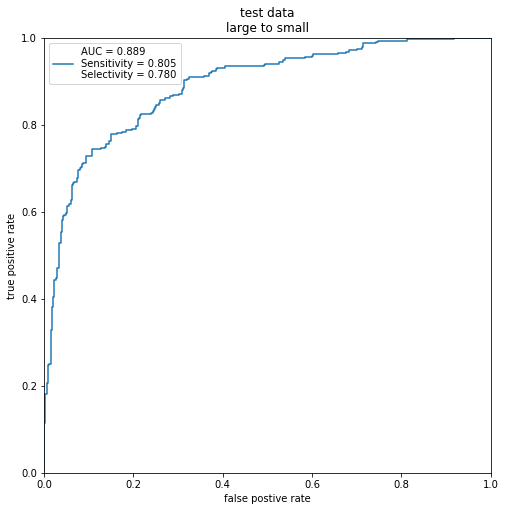

In [30]:
X_predict_ = clf.predict(X_test)[:,-1] > 0.5
X_predict_prob_ = clf.predict_proba(X_test)[1][:,-1]
print(metrics.classification_report(y_test[:,-1],X_predict_))
AUC = metrics.roc_auc_score(y_test[:,-1], X_predict_prob_)
fpr,tpr,th = metrics.roc_curve(y_test[:,-1], X_predict_prob_,pos_label=1)
sensitivity = metrics.precision_score(y_test[:,-1],X_predict_,average='weighted')
selectivity = metrics.recall_score(y_test[:,-1],X_predict_,average='weighted')
plt.close('all')
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(fpr,tpr,label='AUC = %.3f\nSensitivity = %.3f\nSelectivity = %.3f'%(AUC,sensitivity,selectivity))
ax.set(xlabel='false postive rate',ylabel='true positive rate',title='test data\nlarge to small',
       xlim=(0,1),ylim=(0,1))
ax.legend(loc='best')
#fig.savefig(saving_dir_weight + 'test data AUC plot.png',dpi=400)
#plt.close('all')

(array([ 0.25,  1.25]), <a list of 2 Text yticklabel objects>)

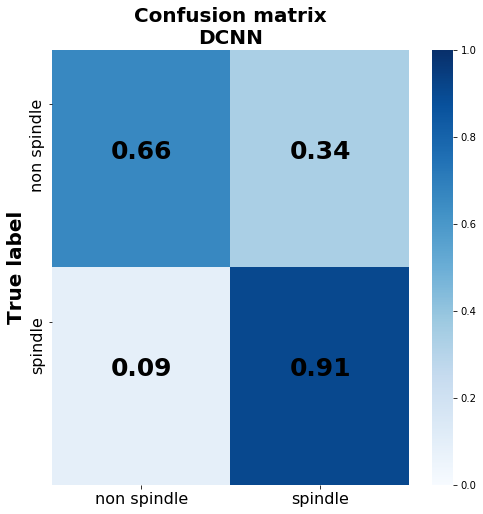

In [31]:
cf =metrics.confusion_matrix(y_test[:,-1],X_predict_)
cf = cf / cf.sum(1)[:, np.newaxis]
import seaborn as sns
plt.close('all')
fig,ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cf,vmin=0.,vmax=1.,cmap=plt.cm.Blues,annot=False,ax=ax)
coors = np.array([[0,0],[1,0],[0,1],[1,1],])+ 0.5
for ii,(m,coor) in enumerate(zip(cf.flatten(),coors)):
    ax.annotate('%.2f'%(m),xy = coor,size=25,weight='bold',ha='center')
ax.set(xticks=(0.5,1.5),yticks=(0.25,1.25),
        xticklabels=['non spindle','spindle'],
        yticklabels=['non spindle','spindle'])
ax.set_title('Confusion matrix\nDCNN',fontweight='bold',fontsize=20)
ax.set_ylabel('True label',fontsize=20,fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig(saving_dir_weight+'confusion matrix.png',dpi=400)

In [32]:
for ii in range(5):
    clf = make_clf()
    for ii in np.random.choice(range(10),10,replace=False):
        X_train_,y_train_ = pickle.load(open('data/train/train%d.p'%(ii),'rb'))
        #random_inputs = np.random.rand(X_train_.shape[0],32,16,192)
        #random_labels = [0]*X_train_.shape[0]
        #random_labels = np_utils.to_categorical(random_labels,2)
        X_train_ = np.concatenate([X_train_,random_inputs],axis=0)
        y_train_ = np.concatenate([y_train_,random_labels],axis=0)
        clf.fit(X_train_,y_train_)
        pred_ = clf.predict(X_validation)
    print(metrics.classification_report(y_validation,pred_))

             precision    recall  f1-score   support

          0       0.85      0.62      0.72       614
          1       0.70      0.88      0.78       599

avg / total       0.77      0.75      0.75      1213

             precision    recall  f1-score   support

          0       0.88      0.58      0.70       614
          1       0.68      0.91      0.78       599

avg / total       0.78      0.75      0.74      1213

             precision    recall  f1-score   support

          0       0.88      0.58      0.70       614
          1       0.68      0.91      0.78       599

avg / total       0.78      0.75      0.74      1213

             precision    recall  f1-score   support

          0       0.86      0.62      0.72       614
          1       0.70      0.90      0.79       599

avg / total       0.78      0.76      0.75      1213

             precision    recall  f1-score   support

          0       0.84      0.72      0.78       614
          1       0.75      0.86 

             precision    recall  f1-score   support

        0.0       0.86      0.70      0.77       354
        1.0       0.72      0.88      0.79       320

avg / total       0.80      0.78      0.78       674



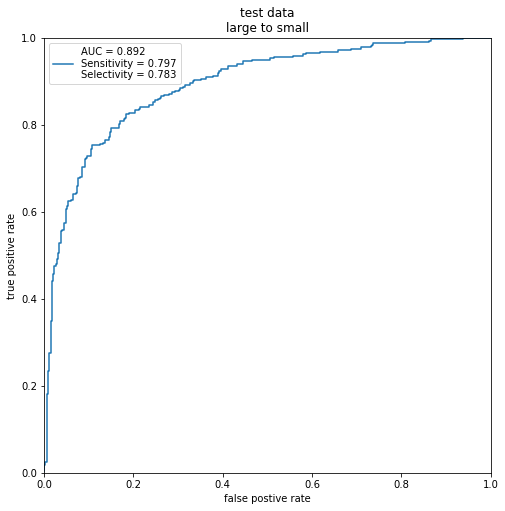

In [33]:
X_predict_ = clf.predict(X_test)[:,-1] > 0.5
X_predict_prob_ = clf.predict_proba(X_test)[1][:,-1]
print(metrics.classification_report(y_test[:,-1],X_predict_))
AUC = metrics.roc_auc_score(y_test[:,-1], X_predict_prob_)
fpr,tpr,th = metrics.roc_curve(y_test[:,-1], X_predict_prob_,pos_label=1)
sensitivity = metrics.precision_score(y_test[:,-1],X_predict_,average='weighted')
selectivity = metrics.recall_score(y_test[:,-1],X_predict_,average='weighted')
plt.close('all')
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(fpr,tpr,label='AUC = %.3f\nSensitivity = %.3f\nSelectivity = %.3f'%(AUC,sensitivity,selectivity))
ax.set(xlabel='false postive rate',ylabel='true positive rate',title='test data\nlarge to small',
       xlim=(0,1),ylim=(0,1))
ax.legend(loc='best')
#fig.savefig(saving_dir_weight + 'test data AUC plot.png',dpi=400)
#plt.close('all')

(array([ 0.25,  1.25]), <a list of 2 Text yticklabel objects>)

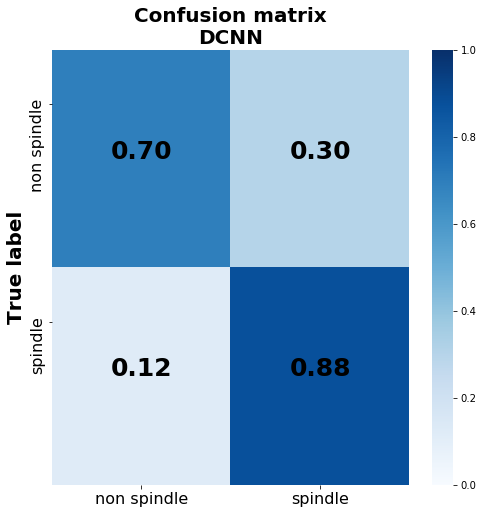

In [34]:
cf =metrics.confusion_matrix(y_test[:,-1],X_predict_)
cf = cf / cf.sum(1)[:, np.newaxis]
import seaborn as sns
plt.close('all')
fig,ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cf,vmin=0.,vmax=1.,cmap=plt.cm.Blues,annot=False,ax=ax)
coors = np.array([[0,0],[1,0],[0,1],[1,1],])+ 0.5
for ii,(m,coor) in enumerate(zip(cf.flatten(),coors)):
    ax.annotate('%.2f'%(m),xy = coor,size=25,weight='bold',ha='center')
ax.set(xticks=(0.5,1.5),yticks=(0.25,1.25),
        xticklabels=['non spindle','spindle'],
        yticklabels=['non spindle','spindle'])
ax.set_title('Confusion matrix\nDCNN',fontweight='bold',fontsize=20)
ax.set_ylabel('True label',fontsize=20,fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig(saving_dir_weight+'confusion matrix.png',dpi=400)